[View in Colaboratory](https://colab.research.google.com/github/neoaksa/tensorflowDemo/blob/master/Weather%20Prediction/weather_prediction.ipynb)

This weather prediction model is used for snowy day in the next few days or hours. Since the weather condition is sequential, it is natural to use RNN to do the prediction.

**Datasource**:  [Local Climatological Data (LCD)](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd), here we picked up hourly condition report in the city of  "Grand Rapids" .

**Target label**: *HourlyPresentWeatherType* where inculds "***SN***".

In [0]:
import keras
import tensorflow as tf
import sys
import pandas as pd
import numpy
import matplotlib.pyplot as plt

The datasource(CSV) is stored in [Google drive](https://drive.google.com/file/d/1ab82uNDDxCGp_O7avHp9ISwyemviwzH_/view?usp=sharing). To save as object in Colab, we have to execute the following code:


In [230]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import auth

# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def downloadFile(inputfilename,outputfilename):
    downloaded = drive.CreateFile({'id': inputfilename})
    # assume the file is called file.csv and it's located at the root of your drive
    downloaded.GetContentFile(outputfilename)
# file download, the param is file id from google drive
FileObj = downloadFile("1ab82uNDDxCGp_O7avHp9ISwyemviwzH_","weather.csv")

The data looks like mixed bunch of information. So, we use some filters to extract what we need:


*   Delete Daily and Monthly columns
*   Reporttype = 'FM-15', METAR Aviation routine weather report
*   Set value to 1 when HOURLYPRSENTWEATHERTYPE contain SN otherwise 0
*   Some dirty data(convert to None)



In [231]:
# have a peek of data
df = pd.read_csv("weather.csv")
df.set_index('DATE', inplace=True)
# only choose winter time sequence
df = df[(pd.to_numeric(df.index.str[5:7])<6) | (pd.to_numeric(df.index.str[5:7])>10)]
df = df[(df.REPORTTPYE=='FM-15')]
df = df.iloc[:,0:25]
# delete duplicate or meanless data
df = df.drop(columns=['STATION_NAME','HOURLYDRYBULBTEMPF','HOURLYWETBULBTEMPF','HOURLYDewPointTempF','HOURLYSKYCONDITIONS','STATION','ELEVATION', 'LATITUDE', 'LONGITUDE','REPORTTPYE'])
df.loc[df['HOURLYPRSENTWEATHERTYPE'].str.contains('SN',na=False),'HOURLYPRSENTWEATHERTYPE'] = 1
df.loc[df['HOURLYPRSENTWEATHERTYPE'] != 1,'HOURLYPRSENTWEATHERTYPE'] = 0
# handle some dirty data
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.fillna(0)
# show example 
df.describe()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,16,17,23,25,44,45,63,64,67,69,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPC,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYWindGustSpeed,HOURLYStationPressure,HOURLYPressureTendency,HOURLYPressureChange,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
count,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000,23968.000000
mean,8.234970,0.127003,3.224395,1.008837,-2.235034,70.129047,10.362901,189.683745,3.859604,29.089068,1.410422,0.000052,29.967051,0.003716,30.011835
std,2.991574,0.332983,9.518192,8.334846,8.687414,17.610532,5.655466,100.310945,9.838010,1.513145,2.565028,0.005285,1.571810,0.019611,0.662129
min,0.000000,0.000000,-24.400000,-24.700000,-28.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.180000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,-3.300000,-4.500000,-8.300000,59.000000,7.000000,100.000000,0.000000,29.000000,0.000000,0.000000,29.880000,0.000000,29.860000
50%,10.000000,0.000000,2.200000,0.800000,-2.200000,72.000000,9.000000,200.000000,0.000000,29.170000,0.000000,0.000000,30.050000,0.000000,30.030000
75%,10.000000,0.000000,9.400000,6.500000,3.300000,84.000000,14.000000,270.000000,0.000000,29.340000,1.000000,0.000000,30.220000,0.000000,30.200000
max,10.000000,1.000000,33.900000,24.300000,23.300000,100.000000,51.000000,360.000000,62.000000,29.880000,8.000000,0.220000,30.810000,0.830000,30.760000


In [0]:
# !pip install ipdb
# import ipdb

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# data generator
# data: input dataframe
# lookback: How many timesteps back should our input data go.
# delay:How many timesteps in the future should our target be.
# min_index and max_index: Indices in the data array that delimit which timesteps to draw from.
# shuffle: Whether to shuffle our samples or draw them in chronological order.
# batch_size: The number of samples per batch.
# step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
# return a iterator
# one hot encoding for target
enc = OneHotEncoder()
enc.fit([[1],[0]])
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=20, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),        # rows size is same as number of batch
                           lookback // step,  # this should be same as each indice
                           data.shape[-1]))   # same as data_scale's column number
        targets = np.zeros((len(rows),2))
        # output processing
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
#             ipdb.set_trace()
            samples[j] = data.iloc[indices]
            targets[j] = enc.transform(data.iloc[rows[j] + delay][1]).toarray()
#             targets[j] = data.iloc[rows[j] + delay][1]
        yield samples, targets
        
# configure constant
lookback = 48  # look back 48 hours
step = 1 # 1 hour
delay = 0 # predict current 
batch_size = 12

# split data for training and validation
max_train = int(df_scaled.shape[0]*0.6)
max_val = int(df_scaled.shape[0]*0.75)
# training set
train_gen = generator(df_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=max_train,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
# validation set
val_gen = generator(df_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=max_train+1,
                    max_index=max_val,
                    step=step,
                    batch_size=batch_size)
# test set
test_gen = generator(df_scaled,
                     lookback=lookback,
                     delay=delay,
                     min_index=max_val+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
val_steps = int((max_val - max_train - lookback) // batch_size)

# This is how many steps to draw from `test_gen`
test_steps = int((len(df_scaled) - max_val+1 - lookback) // batch_size)

# for s,t in test_gen:
#     di = s.shape
#     print(di)
#     print('------------------=============')

In [242]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.layers import Activation, Dense

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, df_scaled.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.2))
model.add(layers.Dense(2,activation='softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=opt, loss='binary_crossentropy')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# evaluate on test
score = model.evaluate_generator(val_gen, 100, workers=12)

predict = model.predict_generator(val_gen, 100, workers=12)
print(len(predict[(predict[:,1]>0.5)]))

# save model
model.save('weather.h5')
# save to google drive folder:1QiH6uMc9VuZLku4rybq8Eey7rR2cBKW1 is id of sharefolder
# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink","id": '1QiH6uMc9VuZLku4rybq8Eey7rR2cBKW1'}]})
f.SetContentFile('weather.h5')
f.Upload()
print('Uploaded file with ID {}'.format(f.get('id')))

Epoch 1/5
500/500 [==============================] - 123s 246ms/step - loss: 0.2279 - val_loss: 0.1820
Epoch 2/5
307/500 [=================>............] - ETA: 37s - loss: 0.1927

500/500 [==============================] - 117s 233ms/step - loss: 0.1934 - val_loss: 0.1727
Epoch 3/5
470/500 [===========================>..] - ETA: 5s - loss: 0.1705

500/500 [==============================] - 116s 233ms/step - loss: 0.1740 - val_loss: 0.1789
Epoch 4/5
500/500 [==============================] - 116s 232ms/step - loss: 0.1848 - val_loss: 0.1749
Epoch 5/5
 32/500 [>.............................] - ETA: 1:31 - loss: 0.1930

500/500 [==============================] - 114s 229ms/step - loss: 0.1750 - val_loss: 0.2009
59
Uploaded file with ID 1bmEfeRW4Fy7vpajX_FpZDylU4JcqzKqW


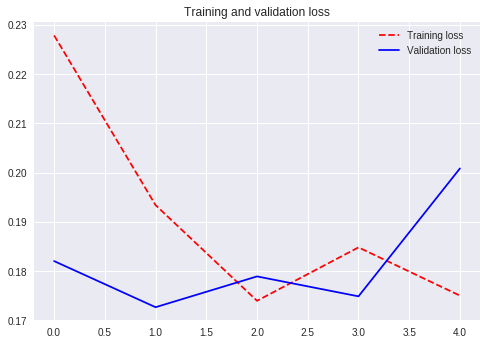

In [243]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
index = 0
correct = 0
for s, t in test_gen:
        pred = model.predict(s)
        for s1,t1 in zip(pred.argmax(axis=1),t.argmax(axis=1)):
            if s1 == t1:
                correct += 1
        index += 1
        
      